# Train model with noisy envelope - full output: envelope + feature

Same flow as in `RNN-Morse-feature` with envelope as in original `label_df`.

In [34]:
!pip install sounddevice torchinfo


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Generate annotated raw signal

Generates the envelope after audio preprocessing. The resulting decimation factor is 128 thus we will take 1 every 128 samples from the original signal modulated at 8 kHz sample rate. This uses a modified version of `encode_df` (`encode_df_decim`) of `MorseGen` thus the original ratio in samples per dit is respected. This effectively takes a floating point ratio (shown in display) for the samples per dit decimation (about 5.77 for the nominal values of 8 kHz sampling rate and 13 WPM Morse code speed) 

The SNR must be calculated in the FFT bin bandwidth. In the original `RNN-Morse-pytorch` notebook the bandwidth is 4 kHz / 256 = 15,625 Hz and SNR is 3 dB. Theoretically you would apply the FFT ratio to the original SNR but this does not work in practice. You have to take a much lower SNR to obtain a similar envelope.

### Base functions

In [35]:
import MorseGen

morsestr = MorseGen.get_morse_str()
print(len(morsestr), morsestr)

158 NQKYDX HGLI8D B28LC F4SHN6 XA21 BBRCEI Y2VV2OCRM NCTH25RB 3YNJ0E IPIX G0 B RATJWFM BT8I M0VDXB MTR 5 75 LXTMX37 BJORI 3FGL 0NRKX LA YQ9T9FF4Q U69987 C0 EDXOZM


### Signal and labels

In [36]:
import matplotlib.pyplot as plt 
import numpy as np

def get_new_data(SNR_dB=-23, nchars=132, nwords=27, phrase=None, dit_randomness_ratio=0):
    if not phrase:
        phrase = MorseGen.get_morse_str(nchars=nchars, nwords=nwords)
    print(len(phrase), phrase)
    Fs = 8000
    morse_gen = MorseGen.Morse()
    samples_per_dit = morse_gen.nb_samples_per_dit(Fs, 13)
    n_prev = int((samples_per_dit/128)*12) + 1 # number of samples to look back is slightly more than a dit-dah and a word space (2+3+7=12)
    print(f'Samples per dit at {Fs} Hz is {samples_per_dit}. Decimation is {samples_per_dit/128:.2f}. Look back is {n_prev}.')
    label_df = morse_gen.encode_df_decim(phrase, samples_per_dit, 128, dit_randomness_ratio*samples_per_dit)
    # keep the envelope
    label_df_env = label_df.drop(columns=['dit','dah', 'ele', 'chr', 'wrd'])
    # remove the envelope
    SNR_linear = 10.0**(SNR_dB/10.0)
    SNR_linear *= 256 # Apply original FFT
    print(f'Resulting SNR for original {SNR_dB} dB is {(10.0 * np.log10(SNR_linear)):.2f} dB')
    t = np.linspace(0, len(label_df_env)-1, len(label_df_env))
    morsecode = label_df_env.env
    power = np.sum(morsecode**2)/len(morsecode)
    noise_power = power/SNR_linear
    noise = np.sqrt(noise_power)*np.random.normal(0, 1, len(morsecode))
    signal = morsecode + noise
    return signal, label_df, n_prev

Try it ...

158 DYRIW NS WWNOQV2RB 85N6 ECMB98O G8SJ IX WWANXP0 D22ME VYZ7U HE95 V EL4MMI 3KF HKQHLP UM1L 9JA2 JSZTO2ABP JZL RY7523X V1JO9 ZE4JF7 DVG XI8 XKE7Q7F QFSLSNEDQ 7X
Samples per dit at 8000 Hz is 738. Decimation is 5.77. Look back is 70.
Resulting SNR for original -17 dB is 7.08 dB
70
<class 'pandas.core.series.Series'> (10149,)
<class 'pandas.core.frame.DataFrame'> (10149, 6)


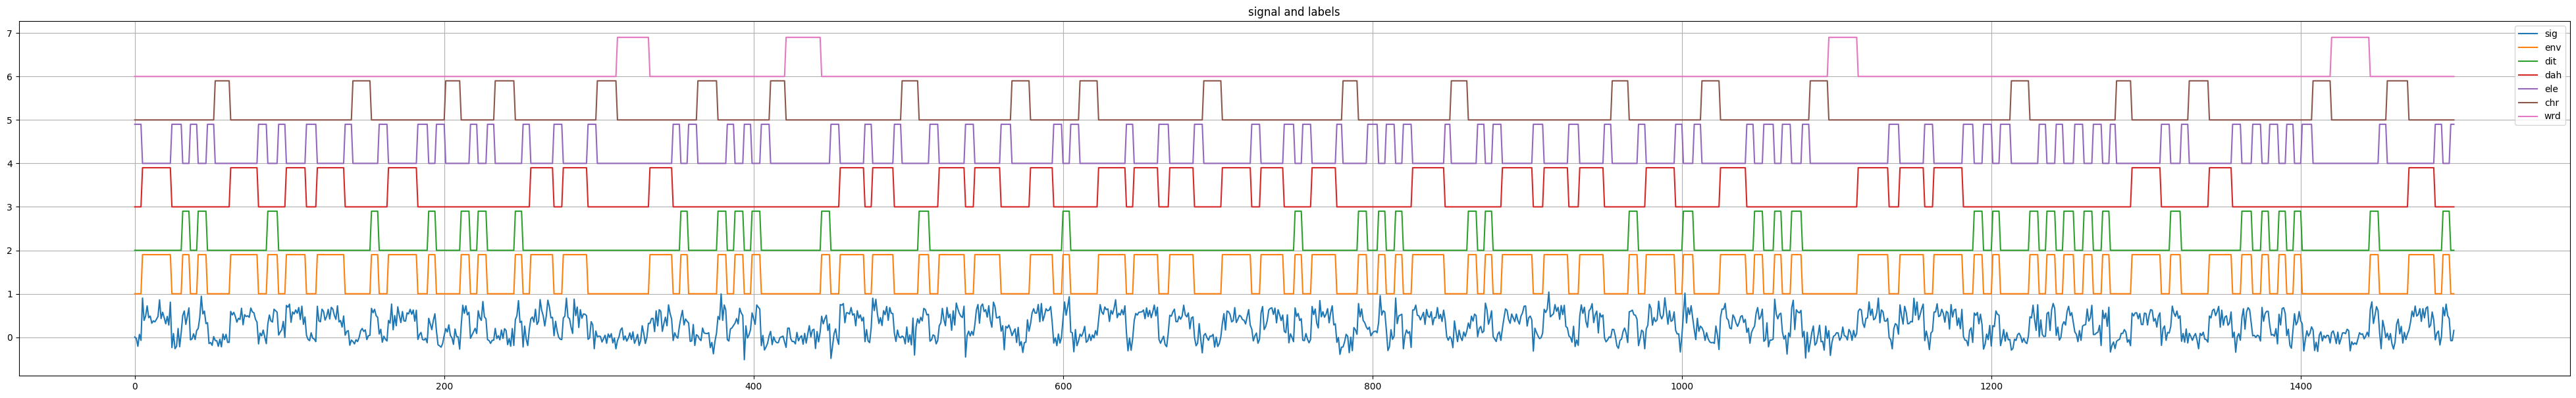

In [37]:
signal, label_df, n_prev = get_new_data(-17, dit_randomness_ratio=0.2)

# Show
print(n_prev)
print(type(signal), signal.shape)
print(type(label_df), label_df.shape)
    
x0 = 0
x1 = 1500

plt.figure(figsize=(50,7))
plt.plot(signal[x0:x1]*0.5, label="sig")
plt.plot(label_df[x0:x1].env*0.9 + 1.0, label='env')
plt.plot(label_df[x0:x1].dit*0.9 + 2.0, label='dit')
plt.plot(label_df[x0:x1].dah*0.9 + 3.0, label='dah')
plt.plot(label_df[x0:x1].ele*0.9 + 4.0, label='ele')
plt.plot(label_df[x0:x1].chr*0.9 + 5.0, label='chr')
plt.plot(label_df[x0:x1].wrd*0.9 + 6.0, label='wrd')
plt.title("signal and labels")
plt.legend()
plt.grid()

## Create data loader
### Define dataset

In [38]:
import torch

class MorsekeyingDataset(torch.utils.data.Dataset):
    def __init__(self, device, SNR_dB=-23, nchars=132, nwords=27, phrase=None, dit_randomness_ratio=0):
        self.signal, self.label_df, self.seq_len = get_new_data(SNR_dB, nchars, nwords, phrase, dit_randomness_ratio=dit_randomness_ratio)
        self.X = torch.FloatTensor(self.signal.values).to(device)
        self.y = torch.FloatTensor(self.label_df.values).to(device)
        
    def __len__(self):
        return self.X.__len__() - self.seq_len

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len])
    
    def get_signal(self):
        return self.signal
    
    def get_labels(self):
        return self.label_df
    
    def get_seq_len(self):
        return self.seq_len()

### Define data loader

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = MorsekeyingDataset(device, -25, 132*2, 27*2, dit_randomness_ratio=0.15)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False) # Batch size must be 1

317 ALR QZI 9UD7YVO C4 28AU2 NC XQKO 4VR58UY UMM9 BAOKJVB WMY FD531 8267 DO8VG 5JEG LKPQ EO04WJ CV1 KUDW KZB0FU JDPUT6 9WI 3RR4G CH0 9WGVGUZ WK5 9BB 4M0ZDYHYW NH2 08Z7LCB DCL ZA6 Y91 TQ8IKXH U5DTM Z36BJXJXX10 R8LF U578BY 612 HEIR LEF6X40X TI6ELLT KUJG OS23XT 1Y AJ2R 5J31353 CNP8C5 W9XE9 0P BWAFA24BA9J5 ATYC HTS1KJ NBPLH
Samples per dit at 8000 Hz is 738. Decimation is 5.77. Look back is 70.
Resulting SNR for original -25 dB is -0.92 dB


<class 'pandas.core.series.Series'> (21174,)
<class 'pandas.core.frame.DataFrame'> (21174, 6)


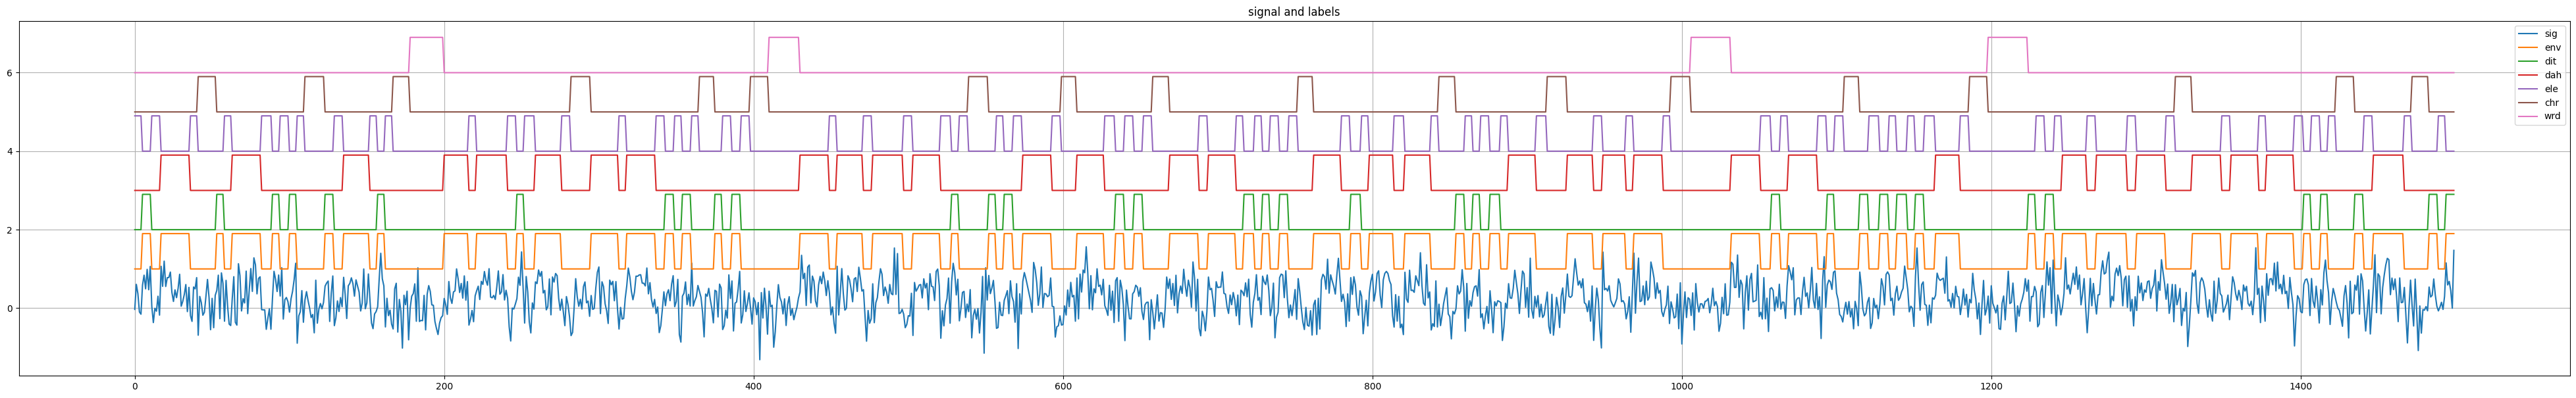

In [40]:
signal = train_dataset.get_signal()
label_df = train_dataset.get_labels()

print(type(signal), signal.shape)
print(type(label_df), label_df.shape)

x0 = 0
x1 = 1500

plt.figure(figsize=(50,7))
plt.plot(signal[x0:x1]*0.5, label="sig")
plt.plot(label_df[x0:x1].env*0.9 + 1.0, label='env')
plt.plot(label_df[x0:x1].dit*0.9 + 2.0, label='dit')
plt.plot(label_df[x0:x1].dah*0.9 + 3.0, label='dah')
plt.plot(label_df[x0:x1].ele*0.9 + 4.0, label='ele')
plt.plot(label_df[x0:x1].chr*0.9 + 5.0, label='chr')
plt.plot(label_df[x0:x1].wrd*0.9 + 6.0, label='wrd')
plt.title("signal and labels")
plt.legend()
plt.grid()

## Create model

Let's create the model now so we have an idea of its inputs and outputs

In [41]:
import torch
import torch.nn as nn

class MorseEnvLSTM(nn.Module):
    """
    Initial implementation
    """
    def __init__(self, device, input_size=1, hidden_layer_size=8, output_size=6):
        super().__init__()
        self.device = device # This is the only way to get things work properly with device
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(self.device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(self.device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
    def zero_hidden_cell(self):
        self.hidden_cell = (
            torch.zeros(1, 1, self.hidden_layer_size).to(device),
            torch.zeros(1, 1, self.hidden_layer_size).to(device)
        )        
    
class MorseEnvBatchedLSTM(nn.Module):
    """
    Initial implementation
    """
    def __init__(self, device, input_size=1, hidden_layer_size=8, output_size=6):
        super().__init__()
        self.device = device # This is the only way to get things work properly with device
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(self.device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(self.device))

    def forward(self, input_seq):
        #print(len(input_seq), input_seq.shape, input_seq.view(-1, 1, 1).shape)
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(-1, 1, 1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
    def zero_hidden_cell(self):
        self.hidden_cell = (
            torch.zeros(1, 1, self.hidden_layer_size).to(device),
            torch.zeros(1, 1, self.hidden_layer_size).to(device)
        )     
    
class MorseEnvLSTM2(nn.Module):
    """
    LSTM stack
    """
    def __init__(self, device, input_size=1, hidden_layer_size=8, output_size=6, dropout=0.2):
        super().__init__()
        self.device = device # This is the only way to get things work properly with device
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(2, 1, self.hidden_layer_size).to(self.device),
                            torch.zeros(2, 1, self.hidden_layer_size).to(self.device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
    def zero_hidden_cell(self):
        self.hidden_cell = (
            torch.zeros(2, 1, self.hidden_layer_size).to(device),
            torch.zeros(2, 1, self.hidden_layer_size).to(device)
        )        
        
class MorseEnvNoHLSTM(nn.Module):
    """
    Do not keep hidden cell
    """
    def __init__(self, device, input_size=1, hidden_layer_size=8, output_size=6):
        super().__init__()
        self.device = device # This is the only way to get things work properly with device
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, 1, self.hidden_layer_size).to(self.device)
        c0 = torch.zeros(1, 1, self.hidden_layer_size).to(self.device)
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1), (h0, c0))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
class MorseEnvBiLSTM(nn.Module):
    """
    Attempt Bidirectional LSTM: does not work
    """
    def __init__(self, device, input_size=1, hidden_size=12, num_layers=1, num_classes=6):
        super(MorseEnvBiLSTM, self).__init__()
        self.device = device # This is the only way to get things work properly with device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x.view(len(x), 1, -1), (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out[-1]    

Create the model instance and print the details

In [42]:
# Hidden layers:
# 4: good at reconstructing signal, some post-processing necessary for dit/dah, word silence is weak and undistinguishable from character silence 
# 5: fairly good at reconstructing signal, but word space sense is lost
# 6: more contrast on all signals and word space sense is good but a spike appears in the silence in predicted envelope
morse_env_model = MorseEnvBatchedLSTM(device, hidden_layer_size=18, output_size=6).to(device) # This is the only way to get things work properly with device
morse_env_loss_function = nn.MSELoss()
morse_env_optimizer = torch.optim.Adam(morse_env_model.parameters(), lr=0.001)

print(morse_env_model)
print(morse_env_model.device)

MorseEnvBatchedLSTM(
  (lstm): LSTM(1, 18)
  (linear): Linear(in_features=18, out_features=6, bias=True)
)
cuda


In [43]:
# Input and hidden tensors are not at the same device, found input tensor at cuda:0 and hidden tensor at cpu
for m in morse_env_model.parameters():
    print(m.shape, m.device)
X_t = torch.rand(n_prev)
#X_t = torch.tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385])
X_t = X_t.cuda()
print(X_t)
morse_env_model(X_t)

torch.Size([72, 1]) cuda:0
torch.Size([72, 18]) cuda:0
torch.Size([72]) cuda:0
torch.Size([72]) cuda:0
torch.Size([6, 18]) cuda:0
torch.Size([6]) cuda:0
tensor([0.9770, 0.3168, 0.6869, 0.2881, 0.5524, 0.8481, 0.1447, 0.7039, 0.8671,
        0.5943, 0.5703, 0.3042, 0.6036, 0.0648, 0.9289, 0.2595, 0.3163, 0.8254,
        0.3206, 0.4482, 0.4638, 0.8076, 0.6339, 0.0639, 0.4685, 0.1894, 0.4703,
        0.5683, 0.8312, 0.2856, 0.6791, 0.8845, 0.6659, 0.6785, 0.7794, 0.9581,
        0.6417, 0.6874, 0.2661, 0.3732, 0.0993, 0.8430, 0.3940, 0.7810, 0.6800,
        0.2593, 0.9384, 0.0327, 0.1454, 0.8721, 0.4551, 0.5828, 0.0029, 0.4748,
        0.8565, 0.1336, 0.6400, 0.9910, 0.0662, 0.8088, 0.0039, 0.3630, 0.6585,
        0.4736, 0.0040, 0.1828, 0.6279, 0.6557, 0.2405, 0.0377],
       device='cuda:0')


tensor([ 0.3239, -0.0373, -0.0477, -0.1981, -0.0287, -0.1220], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [44]:
import torchinfo
channels=10
H=n_prev
W=1
torchinfo.summary(morse_env_model, input_size=(channels, H, W))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [LSTM: 1]

## Train model

In [ ]:
it = iter(train_loader)
X, y = next(it)
print(X.reshape(70,1).shape, X[0].shape, y[0].shape)
print(X[0], y[0])
X, y = next(it)
print(X[0], y[0])

In [ ]:
%%time
from tqdm.notebook import tqdm

epochs = 10
morse_env_model.train()

for i in range(epochs):
    train_losses = []
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for j, train in loop:
        X_train = train[0][0]
        y_train = train[1][0]
        morse_env_optimizer.zero_grad()
        if morse_env_model.__class__.__name__ in ["MorseEnvLSTM", "MorseEnvLSTM2", "MorseEnvBatchedLSTM", "MorseEnvBatchedLSTM2"]:
            morse_env_model.zero_hidden_cell() # this model needs to reset the hidden cell
        y_pred = morse_env_model(X_train)
        single_loss = morse_env_loss_function(y_pred, y_train)
        single_loss.backward()
        morse_env_optimizer.step()
        train_losses.append(single_loss.item())
        # update progress bar
        if j % 1000 == 0:
            loop.set_description(f"Epoch [{i+1}/{epochs}]")
            loop.set_postfix(loss=np.mean(train_losses))

print(f'final: {i+1:3} epochs loss: {np.mean(train_losses):6.4f}')

In [ ]:
save_model = True
if save_model: 
    torch.save(morse_env_model.state_dict(), 'models/morse_env_model')
else:
    morse_env_model.load_state_dict(torch.load('models/morse_env_model_full_07_3', map_location=device))

### Predict (test)

In [ ]:
new_phrase = "VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB VVV DE F4EXB"
test_dataset = MorsekeyingDataset(device, -20, 132, 27, new_phrase, dit_randomness_ratio=0.075)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False) # Batch size must be 1

In [ ]:
signal = test_dataset.get_signal()
label_df = test_dataset.get_labels()

print(type(signal), signal.shape)
print(type(label_df), label_df.shape)

x0 = 0
x1 = 3000

plt.figure(figsize=(50,7))
plt.plot(signal[x0:x1]*0.9, label="sig")
plt.plot(label_df[x0:x1].env*0.9 + 1.0, label='env')
plt.plot(label_df[x0:x1].dit*0.9 + 2.0, label='dit')
plt.plot(label_df[x0:x1].dah*0.9 + 3.0, label='dah')
plt.plot(label_df[x0:x1].ele*0.9 + 4.0, label='ele')
plt.plot(label_df[x0:x1].chr*0.9 + 5.0, label='chr')
plt.plot(label_df[x0:x1].wrd*0.9 + 6.0, label='wrd')
plt.title("signal and labels")
plt.legend()
plt.grid()

In [ ]:
%%time
p_env_l = []
p_dit_l = []
p_dah_l = []
p_ele_l = []
p_chr_l = []
p_wrd_l = []
y_test_a = []
morse_env_model.eval()

for X_test0, y_test0 in test_loader:
    X_test = X_test0[0]
    pred_val = morse_env_model(X_test).cpu()
    p_env_l.append(pred_val[0].item())
    p_dit_l.append(pred_val[1].item())
    p_dah_l.append(pred_val[2].item())
    p_ele_l.append(pred_val[3].item())
    p_chr_l.append(pred_val[4].item())
    p_wrd_l.append(pred_val[5].item())
    y_test_a.append(y_test0[0,0])
        
p_env = np.array(p_env_l)
p_dit = np.array(p_dit_l)
p_dah = np.array(p_dah_l)
p_ele = np.array(p_ele_l)
p_chr = np.array(p_chr_l)
p_wrd = np.array(p_wrd_l)
y_test_v = np.array(y_test_a)

# trim negative values
p_env[p_env < 0] = 0
p_dit[p_dit < 0] = 0
p_dah[p_dah < 0] = 0
p_ele[p_ele < 0] = 0
p_chr[p_chr < 0] = 0
p_wrd[p_wrd < 0] = 0

In [ ]:
plt.figure(figsize=(50,7))
plt.plot(y_test_v[:x1]*0.9, label="y")
plt.plot(p_env[:x1]*0.9 + 1.0, label="env")
plt.plot(p_dit[:x1]*0.9 + 2.0, label="dit")
plt.plot(p_dah[:x1]*0.9 + 3.0, label="dah")
plt.plot(p_ele[:x1]*0.9 + 4.0, label="ele")
plt.plot(p_chr[:x1]*0.9 + 5.0, label="chr")
plt.plot(p_wrd[:x1]*0.9 + 6.0, label="wrd")
plt.title("Predictions")
plt.legend()
plt.grid()
plt.savefig('img/pred.png')

In [ ]:
l_test = signal[n_prev:].to_numpy()
sig = p_dit[:x1] + p_dah[:x1]
sig = (sig - min(sig)) / (max(sig) - min(sig))
mor = y_test_v[:x1]
plt.figure(figsize=(50,3))
plt.plot(sig, label="mod")
plt.plot(l_test[:x1] + 1.0, label="sig")
plt.plot(mor*2.2, label="mor", linestyle='--')
plt.title("reconstructed signal modulation with 'dah' and 'dit'")
plt.legend()
plt.grid()

In [ ]:
plt.figure(figsize=(50,4))
plt.plot(p_dit[:x1], label='dit')
plt.plot(p_dah[:x1], label='dah')
plt.plot(mor*0.5 + 1.0, label='mor')
plt.title("'dit' and 'dah' symbols prediction vs modulation")
plt.legend()
plt.grid()

In [ ]:
plt.figure(figsize=(50,3))
plt.plot(p_ele[:x1], label='ele')
plt.plot(mor, label='mor')
plt.title("Element space prediction vs modulation")
plt.legend()

In [ ]:
plt.figure(figsize=(50,3))
plt.plot(p_chr[:x1] ,label='chr')
plt.plot(mor, label='mor')
plt.title("Character space prediction vs modulation")
plt.legend()

In [ ]:
plt.figure(figsize=(50,3))
plt.plot(p_wrd[:x1], label='wrd')
plt.plot(mor, label='mor')
plt.title("Word space prediction vs modulation")
plt.legend()

In [ ]:
#p_sig = 1.0 - (p_ele + p_chr + p_wrd)
p_sig = p_dit + p_dah
p_ditd = p_dit - p_dah
p_dahd = p_dah - p_dit
plt.figure(figsize=(50,8))
plt.plot(l_test[:x1]*0.9, label="inp")
plt.plot(p_sig[:x1]*0.9 + 1.0, label="sig")
plt.plot(p_dit[:x1]*0.9 + 2.0, label="dit")
plt.plot(p_dah[:x1]*0.9 + 3.0, label="dah")
plt.plot(p_ele[:x1]*0.9 + 4.0, label="ele")
plt.plot(p_chr[:x1]*0.9 + 5.0, label="chr")
plt.plot(p_wrd[:x1]*0.9 + 6.0, label="wrd")
plt.plot(mor*7.2, label="mor")
plt.title("Altogether vs signal and modulation")
plt.legend()
plt.grid()
plt.figure(figsize=(50,4))
plt.plot(p_dit[:x1]*0.9 + 0.0, label="dit")
plt.plot(p_dahd[:x1]*0.9 + 1.0, label="dahd")
plt.plot(p_ele[:x1]*0.9 + 2.0, label="ele")
plt.plot(mor*3.2, label="mor")
plt.title("Differential dah")
plt.legend()
plt.grid()

In [ ]:
import scipy as sp
import scipy.special
from scipy.io import wavfile

Fcode = 600
Fs = 8000
noverlap = 128
decim = 128
emod = np.array([sp.special.expit(8*(0.9*x-0.5)) for x in sig])
#emod = sig
emod /= max(emod)
remod = np.array([[x]*noverlap for x in emod]).flatten()
wt = (Fcode / Fs)*2*np.pi
tone = np.sin(np.arange(len(remod))*wt)
wavfile.write('audio/re.wav', Fs, tone*remod)
ref_mod = np.array([[x]*decim for x in mor]).flatten()
plt.figure(figsize=(50,5))
plt.plot(tone*remod)
plt.plot(ref_mod*1.2, label='mor')
plt.title("reconstructed signal")
plt.grid()
# .4QTV4PB EZ1 JBGJ TT1W4M...
# 7U7K 0DC55B H ZN0J Q9 H2X0 LZ16A ECA2DE 6A2 NUPU 67IL6EIH YVZA 5OTGC3U C3R PGW RS0 84QTV4PB EZ1 JBGJ TT1W4M5PBJ GZVLWXQG 7POU6 FMTXA N3CZ Y1Q9VZ6 9TVL CWP8KSB'

In [ ]:
omod = l_test[:x1]
orig_mod = np.array([[x]*decim for x in omod]).flatten()
orig_mod /= max(orig_mod)
orig_mod *= 1.5
wavfile.write('audio/or.wav', Fs, tone*orig_mod)
plt.figure(figsize=(25,5))
plt.plot(tone*orig_mod)
plt.plot(ref_mod*1.2, label='mor')
plt.title("original filtered signal")
plt.grid()

In [ ]:
import scipy as sp

sx = np.linspace(0, 1, 121)
sy = sp.special.expit(6*(0.9*sx-0.5))
plt.plot(sx, sy)
plt.grid()
plt.xlabel('x')
plt.title('expit(x)')
plt.show()